# Simple pendulum system

<img align="right" width="150" src="pendulum.png">

Consider a simple pendulum of length $l$ and mass $m$ concentrated at its bob. The pivot of the pendulum is attached to a fix point. The system is submitted to a uniform, constant gravitational acceleration field $g$ and moves without friction.

The generalised coordinate of the system is the angle $\theta$ of the pendulum with the downward vertical direction. The standard (Cartesian) coordinates of the bob are then given by

\begin{equation*}
x = l\sin\theta
\hspace{2cm}
y = -l\cos\theta
\end{equation*}

The only active force is weight with coordinates $(0,-mg)$, hence of the form $-\nabla V$ with $V=mgy=-mgl\cos\theta$. Hence the Lagrangian

\begin{equation*}
\mathcal{L} = ml^2(\frac{1}{2}\dot{\theta}^2+\frac{g}{l}\cos\theta)
\end{equation*}

The equations of the dynamics are given by:

\begin{align*}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1.5cm} &
\ddot{\theta} = -\frac{g}{l}\sin\theta
\end{align*}

Multiplying that equation by $\dot{\theta}$ and integrating yields $\dot{E}=0$ where $E$ is the total energy (constant) defined by

\begin{equation*}
E\triangleq\frac{1}{2}\dot{\theta}^2-\frac{g}{l}\cos\theta
\hspace{2cm}
\dot{E}=0
\end{equation*}

The time domain $\mathcal{D}^{(t)}$ is necessarily $\mathbb{R}$.


In [1]:
import logging; logging.basicConfig(level=logging.WARNING); logging.captureWarnings(True)
from numpy import sin,cos,pi,arccos,degrees,radians,sqrt,array,square,isclose
from ipyshow.odesimu import ODESystem
from collections import namedtuple
from enum import Enum
Periodicity = Enum('Periodicity','Aperiodic Periodic IncrementalPeriodic')
Analytics = namedtuple('Analytics','E alpha periodicity T name displayer')

## Pendulum class

In [2]:
#----------------------------------------------------------------------------------------------------
class Pendulum (ODESystem):
#----------------------------------------------------------------------------------------------------

  def __init__(self,L,G):
    r"""
Args:
  L (float): length of the pendulum [m]
  G (float): intensity of the gravitation [m.sec^-2]
    """
    self.L, self.G = L, G
    self.a = a = G/L
    def fun(t,state):
      θ,θʹ = state
      θʺ = -a*sin(θ)
      return array((θʹ,θʺ))
    self.fun = fun
    def jac(t,state):
      θ,θʹ = state
      return array(((0,1),(-a*cos(θ),0)))
    self.jac = jac
    def cartesian(state):
      θ,θʹ = state
      return L*array((sin(θ),-cos(θ)))
    self.cartesian = cartesian
    super().__init__()

  def displayer(self,trajectory,ax,refsize=None):
    Q = self.analytics(trajectory.init_y)
    ax.set_title(Q.name,fontsize='x-small')
    L = 1.05*self.L
    ax.set(xlim=(-L,L),ylim=(-L,L))
    ax.scatter((0.,),(0.,),c='k',marker='o',s=refsize)
    Q.displayer(ax)
    a_pole, = ax.plot((),(),'k')
    a_bob = ax.scatter((),(),s=refsize,marker='o',c='r')
    a_tail, = ax.plot((),(),'y')
    def disp(t):
      x,y = self.cartesian(trajectory.state(t))
      a_pole.set_data((0,x),(0,y))
      a_bob.set_offsets(((x,y),))
      a_tail.set_data(*self.cartesian(trajectory.cached(t)))
    return disp

  @staticmethod
  def makestate(θ,θʹ=0.):
    r"""
Args:
  θ (float): angle [deg]
  θʹ (float): angular speed [deg.sec^-1]
    """
    return radians((θ,θʹ))

  def analytics(self,ini):
    from scipy.integrate import quad
    θ,θʹ = ini
    E = .5*square(θʹ)-self.a*cos(θ)
    c = -E/self.a
    if isclose(c,-1):
      α,periodicity,T,fmt = pi,Periodicity.Aperiodic,None,'aperiodic'
    else:
      α,periodicity,fmt = (pi,Periodicity.IncrementalPeriodic,'incremental period: {:.2f}') if c<-1 else (arccos(c),Periodicity.Periodic,'half-period: {:.2f}')
      T = pi/sqrt(2) if isclose(α,0.) else quad((lambda θ,c=c: 1/sqrt(cos(θ)-c)),0,α)[0]
      T *= sqrt(2/self.a)
    name = f'CircularArc($R={self.L:.2f},\\alpha={degrees(α):.2f}^\\circ$) {fmt.format(T)}'
    def displayer(ax):
      from matplotlib.patches import Arc
      ax.set_title(f'Motion:{name}',fontsize='x-small')
      ax.scatter(*zip(*map(self.cartesian,((-α,0),(α,0)))),marker='+',c='k')
      ax.add_patch(Arc((0,0),2*self.L,2*self.L,angle=-90,theta1=-degrees(α),theta2=degrees(α),color='k',ls='dashed'))
    return Analytics(E,α,periodicity,T,name,displayer)

  trajectory_defaults = {'period':10.,'cache_spec':(10,.05),'max_step':.05}

IPYControlledAnimation(children=(VBox(children=(HBox(children=(SimpleButton(icon='close', layout=Layout(paddin…

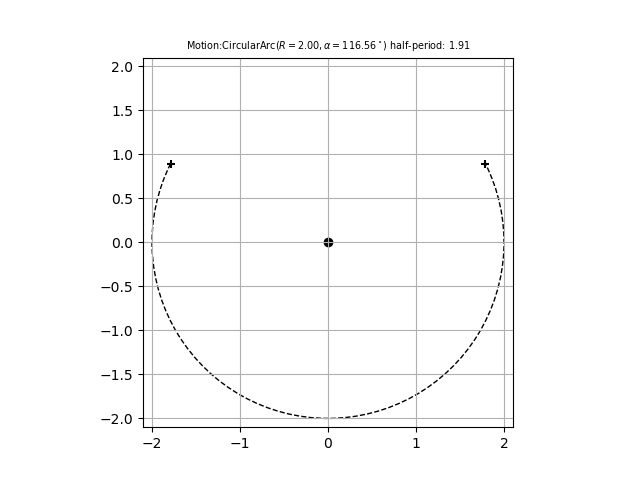

In [3]:
%matplotlib widget
#%matplotlib qt6

syst = Pendulum(L=2.,G=9.81,)
ini = dict(θ=90.,θʹ=120.)
#ini = dict(θ=90.,jumpθʹ=181)
#ini = dict(θ=179.)
#ini = dict(θ=90.jump,θʹ=degrees(sqrt(syst.G))) # should be aperiodic, but appears periodic due to numerical errors

R = syst.simulation(init_y=ini)
R.play(frame_per_stu=25,track_spec=60.)

## Trajectory

The trajectory is a circle arc (or full circle).The equation of the total energy is given by $\dot{\theta}^2=\frac{2g}{l}(\cos\theta-c)$ where $c=-\frac{El}{g}$. Note that by construction $c\leq1$.

### Properties of the solution

For any instant $\tau$, we have

\begin{equation*}
\textrm{If}\;\;
\theta(\tau)\equiv{0}\mod{\pi}
\;\;\textrm{then}\;\;
\theta(2\tau-t) = 2\theta(\tau)-\theta(t)
\end{equation*}

Hence, under the given condition, the graph of $\theta(t)$ is symmetric around $(\tau,\theta(\tau))$. Indeed

* Consider $\tilde{\theta}(t)=2\theta(\tau)-\theta(2\tau-t)$. In particular, $\tilde{\theta}(\tau)=\theta(\tau)$ and $\dot{\tilde{\theta}}(\tau)=\dot{\theta}(\tau)$.
* By design, if $\theta(\tau)\equiv{0}\mod{\pi}$, then $\tilde{\theta}$ satisfies the same Lagrangian differential equation as $\theta$.
* Since they coincide as well as their derivatives at $\tau$, they are equal. Hence $\theta(2\tau-t) = 2\theta(\tau)-\theta(t)$.

Similarly, we can show, using the constant function $\tilde{\theta}(t)=\theta(\tau)$:

\begin{equation*}
\textrm{If}\;\;
\theta(\tau)\equiv{0}\mod{\pi}
\;\;\textrm{and}\;\;
\cos(\theta(\tau))=c
\;\;\textrm{then}\;\;
\theta(t) = \theta(\tau)
\end{equation*}

Since $\mathcal{D}^{(\theta)}$ is an interval, there are 3 cases.

* If $\mathcal{D}^{(\theta)}$ is the singleton $\{\theta_o\}$, we must have $\dot{\theta}_o=0$ hence $\cos\theta_o=c$ and $\ddot{\theta}_o=0$ hence $\sin\theta_o=0$. Hence $\theta_o\equiv{0}\mod{\pi}$ and $c=\pm1$. The trajectory is reduced to either the top or bottom point of the circle.

* If $\mathcal{D}^{(\theta)}$ is unbounded on at least one side
  * it must contain some $\theta(\tau)=k\pi$ for some $k\in\mathbb{Z}$ sufficiently large (positive or negative).
  * Hence $\mathcal{D}^{(\theta)}$ is symmetric around $\tau$, hence it must be unbounded on both sides, i.e. $\mathcal{D}^{(\theta)}=\mathbb{R}$.
  * Hence, the trajectory is the whole circle, and for some $t^*,T$ we have $\theta(t^*)=0$ and $\theta(t^*+T)=\pi$.
  * Hence $-1-c=\cos\theta(t^*+T)-c=\frac{l}{2g}\dot{\theta}(t^*+T)^2\geq0$ hence $c\leq-1$.
  * In fact, $c=-1$ is impossible, because in that case $\cos\theta(t^*+T)=c$ and $\theta$ would be constant, hence $c<-1$.
  * Hence $\dot{\theta}\not=0$ and $\theta$ is monotonous in $t$, i.e. for some $\epsilon\in\{-1,1\}$ we have $\dot{\theta}=\epsilon\sqrt{\frac{2g}{l}}\sqrt{\cos\theta-c}$.
  * By symmetry at $t^*+T$ we get $\theta(t^*+2T)=2\pi$.
  * Considering $\tilde{\theta}(t)=\theta(t+2T)-2\pi$, it is easy to show that $\tilde{\theta}$ and $\theta$, as well as their derivatives, coincide at $t^*$.
  * They satisfy the same differential equation, hence they are equal.
  * Hence $\theta$ is incremental periodic of half-period $T$.

* If $\mathcal{D}^{(\theta)}$ is bounded on both side, let $\theta_{\textrm{min}},\theta_{\textrm{max}}$ be its lower and upper bound, respectively.
  * If $\theta_{\textrm{min}}=\theta(\tau)$ for some $\tau$, then $\theta$ is minimal at $\tau$ hence $\dot{\theta}(\tau)=0$ hence $\cos(\theta_{\textrm{min}})=c$.
  * Otherwise, $\theta_{\textrm{min}}$ must be a limit point, i.e. $\theta_{\textrm{min}}=\lim_{t\rightarrow\tau}\theta(t)$ for $\tau=\pm\infty$. Hence $\delta\triangleq\lim_{t\rightarrow\tau}\dot{\theta}(t)=\frac{2g}{l}(\cos\theta_{\textrm{min}}-c)$. By L'Hôpital rule, we get $\delta=\lim_{t\rightarrow\tau}\frac{\theta(t)}{t}=\lim_{t\rightarrow\tau}\frac{\theta_{\textrm{min}}}{t}=0$.
  * Hence, in all cases, and reasoning similarly with $\theta_{\textrm{max}}$, we get $\cos(\theta_{\textrm{min}})=\cos(\theta_{\textrm{max}})=c$, and $\cos\theta\geq c$ for all $\theta\in[\theta_{\textrm{min}},\theta_{\textrm{max}}]$.
  * Hence $-1\leq c<1$.

### Periodicity when $-1<c<1$

When $|c|<1$, the motion is periodic and, since $c=\cos\alpha$, the **half-period** is given by

\begin{equation*}
T=\sqrt{\frac{2l}{g}}I(\alpha)
\hspace{1cm}\textrm{where}\hspace{1cm}
I(\alpha)\triangleq\int_0^\alpha\frac{\mathbf{d}\theta}{\sqrt{\cos\theta-\cos\alpha}}
\end{equation*}
Using the change of variable $\theta=t\alpha$, we get
\begin{equation*}
T=\int_0^1\frac{\alpha\mathbf{d}t}{\sqrt{\cos t\alpha-\cos\alpha}} =
\int_0^1\frac{\alpha\mathbf{d}t}{\sqrt{2\sin\frac{1+t}{2}\alpha\sin\frac{1-t}{2}\alpha}}
\end{equation*}

When $t\rightarrow1$, we have $2\sin\frac{1+t}{2}\alpha\sin\frac{1-t}{2}\alpha\sim(1-t)\alpha\sin\alpha$ and since $\int_0^1\frac{\mathbf{d}t}{\sqrt{1-t}}=2$ is finite, so is $I(\alpha)$. Furthermore, the integrand is monotone increasing in $\alpha$, hence so is $I(\alpha)$.

* When $\alpha\rightarrow0^+$, the integrand converges pointwise to $\sqrt{\frac{2}{1-t^2}}$ and is dominated by $\frac{\pi}{2}\sqrt{\frac{2}{1-t^2}}$. This is shown, when $\alpha\leq\frac{\pi}{2}$, using the inequality $\sin(x)\geq\frac{2}{\pi}x$ for any $0\leq x\leq\frac{\pi}{2}$. By the [dominated convergence theorem](https://en.wikipedia.org/wiki/Dominated_convergence_theorem), using the change of variable $t=\sin u$, we have
\begin{equation*}
\lim_{\alpha\rightarrow0^+}I(\alpha) = \int_0^1\frac{\sqrt{2}\mathbf{d}t}{\sqrt{1-t^2}} =
\int_0^{\frac{\pi}{2}}\frac{\sqrt{2}\cos u\mathbf{d}u}{\sqrt{1-\sin^2u}} = \frac{\pi}{\sqrt{2}}
\end{equation*}
Hence
\begin{equation*}
\lim_{c\rightarrow1^-}T = \pi\sqrt{\frac{l}{g}}
\end{equation*}

* When $\alpha\rightarrow\pi^-$, the integrand converges pointwise increasingly to $\frac{\pi}{\sqrt{2}\cos(\frac{\pi}{2}t)}$. By the [monotone convergence theorem](http://en.wikipedia.org/wiki/Monotone_convergence_theorem), using the change of variable $t=1-\frac{2u}{\pi}$, we have
\begin{equation*}
\lim_{\alpha\rightarrow\pi^-}I(\alpha) = \int_0^1\frac{\pi\mathbf{d}t}{\sqrt{2}\cos(\frac{\pi}{2}t)} =
\sqrt{2}\int_0^{\frac{\pi}{2}}\frac{\mathbf{d}u}{\sin u} = \infty
\end{equation*}
Hence
\begin{equation*}
\lim_{c\rightarrow-1^+}T = \infty
\end{equation*}

### Incremental periodicity when $c<-1$

When $c<-1$, the motion is incremental periodic and the **incremental period** is given by

\begin{equation*}
T = \sqrt{\frac{2l}{g}}\int_0^\pi\frac{\mathbf{d}\theta}{\sqrt{\cos\theta-c}}
\end{equation*}

When $c\rightarrow-1^-$, the integrand converges pointwise increasingly to $\frac{1}{\sqrt{1+\cos\theta}}$. By the monotone convergence theorem, and using the change of variable $\theta=\pi-2u$, we have
\begin{equation*}
\lim_{c\rightarrow-1^-}T = \sqrt{\frac{2l}{g}}\int_0^\pi\frac{\mathbf{d}\theta}{\sqrt{1+\cos\theta}} =
2\sqrt{\frac{l}{g}}\int_0^{\frac{\pi}{2}}\frac{\mathbf{d}u}{\sin u} = \infty
\end{equation*}